In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

In [2]:
class LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        combined_size = self.input_size + self.hidden_size
        self.in_gate = nn.Linear(combined_size, self.hidden_size)
        self.forget_gate = nn.Linear(combined_size, self.hidden_size)
        self.new_cell_state = nn.Linear(combined_size, self.hidden_size)
        self.out_gate = nn.Linear(combined_size, self.hidden_size)

    def forward(self, inputs, state=None):
        B, _ = inputs.shape                                 # (B,     I)
        # state: ((B, H), (B, H))
        if state is None:
            state = self.init_state(B, inputs.device)
        hs, cs = state
        combined = torch.cat((inputs, hs), dim=1)           # (B, I + H)
        ingate = F.sigmoid(self.in_gate(combined))          # (B,     H)
        forgetgate = F.sigmoid(self.forget_gate(combined))  # (B,     H)
        outgate = F.sigmoid(self.out_gate(combined))        # (B,     H)
        # 更新细胞状态
        ncs = F.tanh(self.new_cell_state(combined))         # (B,     H)
        cs = (forgetgate * cs) + (ingate * ncs)             # (B,     H)
        # 更新隐藏状态
        hs = outgate * F.tanh(cs)                           # (B,     H)
        return hs, cs

    def init_state(self, B, device):
        cs = torch.zeros((B, self.hidden_size), device=device)
        hs = torch.zeros((B, self.hidden_size), device=device)
        return hs, cs

class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = LSTMCell(self.input_size, self.hidden_size)

    def forward(self, inputs, state=None):
        re = []
        # B batch_size,
        # T sequence length,
        # C number of channels.
        B, T, C = inputs.shape
        inputs = inputs.transpose(0, 1)  # (T, B, C)
        for i in range(T):
            state = self.lstm(inputs[i], state)
            re.append(state[0])  # state[0]: (B, H)
        result_tensor = torch.stack(re, dim=0)  # (T, B, H)
        return result_tensor.transpose(0, 1)    # (B, T, H)

In [3]:
def test_lstm():
    B, T, input_size, hidden_size, num_layers = torch.randint(1, 20, (5,)).tolist()
    ref_model = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
    # 随机生成输入
    inputs = torch.randn(B, T, input_size)
    hs, cs = torch.randn((2 * num_layers, B, hidden_size)).chunk(2, 0)
    _hs = list((i.squeeze(0) for i in hs))
    _cs = list((i.squeeze(0) for i in cs))
    re = inputs
    # 取出模型参数
    for layer_index in range(num_layers):
        l = ref_model.all_weights[layer_index]
        if layer_index == 0:
            model = LSTM(input_size, hidden_size)
        else:
            model = LSTM(hidden_size, hidden_size)
        i, f, c, o = torch.cat((l[0], l[1]), dim=1).chunk(4, 0)
        ib, fb, cb, ob = (l[2] + l[3]).chunk(4, 0)
        # 设置模型参数
        model.lstm.in_gate.weight = nn.Parameter(i)
        model.lstm.in_gate.bias = nn.Parameter(ib)
        model.lstm.forget_gate.weight = nn.Parameter(f)
        model.lstm.forget_gate.bias = nn.Parameter(fb)
        model.lstm.new_cell_state.weight = nn.Parameter(c)
        model.lstm.new_cell_state.bias = nn.Parameter(cb)
        model.lstm.out_gate.weight = nn.Parameter(o)
        model.lstm.out_gate.bias = nn.Parameter(ob)
        # 验证计算结果
        re = model(re, (_hs[layer_index], _cs[layer_index]))
    ref_re, _ = ref_model(inputs, (hs, cs))
    out = torch.all(re - ref_re < 1e-4)
    return out, (B, T, input_size, hidden_size, num_layers)

test_lstm()

(tensor(True), (2, 17, 15, 16, 15))

In [4]:
learning_rate = 1e-3
eval_iters = 10
batch_size=1000
sequence_len=64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
raw_datasets = load_dataset("code_search_net", "python")
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repository_name'])

class char_tokenizer:

    def __init__(self, data):
        # 数据中出现的所有字符构成字典
        chars = sorted(list(set(''.join(data))))
        # 预留一个位置给结尾的特殊字符
        self.char2ind = {s : i + 1 for i, s in enumerate(chars)}
        self.char2ind['<|e|>'] = 0
        self.ind2char = {i : s for s, i in self.char2ind.items()}

    def encode(self, text):
        return [self.char2ind[c] for c in text]

    def decode(self, enc):
        if isinstance(enc, int):
            return self.ind2char[enc]
        return [self.ind2char[i] for i in enc]

tok = char_tokenizer(datasets['whole_func_string'])
len(tok.char2ind)

98

In [6]:
class CharLSTM(nn.Module):

    def __init__(self, vs):
        super().__init__()
        self.emb_size = 256
        self.hidden_size = 128
        self.embedding = nn.Embedding(vs, self.emb_size)
        self.dp = nn.Dropout(0.4)
        self.lstm1 = LSTM(self.emb_size, self.hidden_size)
        self.norm1 = nn.LayerNorm(self.hidden_size)
        self.lstm2 = LSTM(self.hidden_size, self.hidden_size)
        self.norm2 = nn.LayerNorm(self.hidden_size)
        self.lstm3 = LSTM(self.hidden_size, self.hidden_size)
        self.norm3 = nn.LayerNorm(self.hidden_size)
        self.h2o = nn.Linear(self.hidden_size, vs)

    def forward(self, x):
        # x: (B, T)
        emb = self.embedding(x)                   # (B, T,  C)
        h = self.norm1(self.dp(self.lstm1(emb)))  # (B, T,  H)
        h = self.norm2(self.dp(self.lstm2(h)))    # (B, T,  H)
        h = self.norm3(self.dp(self.lstm3(h)))    # (B, T,  H)
        output = self.h2o(h)                      # (B, T, vs)
        return output

model = CharLSTM(len(tok.char2ind)).to(device)

In [7]:
model

CharLSTM(
  (embedding): Embedding(98, 256)
  (dp): Dropout(p=0.4, inplace=False)
  (lstm1): LSTM(
    (lstm): LSTMCell(
      (in_gate): Linear(in_features=384, out_features=128, bias=True)
      (forget_gate): Linear(in_features=384, out_features=128, bias=True)
      (new_cell_state): Linear(in_features=384, out_features=128, bias=True)
      (out_gate): Linear(in_features=384, out_features=128, bias=True)
    )
  )
  (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lstm2): LSTM(
    (lstm): LSTMCell(
      (in_gate): Linear(in_features=256, out_features=128, bias=True)
      (forget_gate): Linear(in_features=256, out_features=128, bias=True)
      (new_cell_state): Linear(in_features=256, out_features=128, bias=True)
      (out_gate): Linear(in_features=256, out_features=128, bias=True)
    )
  )
  (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lstm3): LSTM(
    (lstm): LSTMCell(
      (in_gate): Linear(in_features=256, out_features=128, bias=Tru

In [8]:
@torch.no_grad()
def generate_batch(model, idx, max_new_tokens=300):
    # 将模型切换至评估模式
    model.eval()
    for _ in range(max_new_tokens):
        # 限制背景长度，使之与模型训练时的状况更相符
        # 当然也可以不限制
        context = idx[:, -sequence_len:]
        logits = model(context)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, ix), dim=1)
        if ix.item() == 0:
            break
    # 将模型切换至训练模式
    model.train()
    return idx.tolist()[0]

In [9]:
begin_text = torch.tensor(tok.encode('def'), device=device).unsqueeze(0)
print(''.join(tok.decode(generate_batch(model, begin_text))))

def*$O(h/of("YP{so.8G|1w=3:1'ZS?z9)N[{3Q=CKfAM:iEca";+Q31<sA..WS$M0Nx!qyT3jyMö54a)'W~]\r/&B"T{Y
cdtM>SDax1zk<|e|>


In [10]:
def process(data, sequence_len=sequence_len):
    text = data['whole_func_string']
    inputs, labels = [], []
    for i in text:
        enc = tok.encode(i)
        enc += [0]
        for i in range(len(enc) - sequence_len):
            inputs.append(enc[i: i + sequence_len])
            labels.append(enc[i + 1: i + 1 + sequence_len])
    return {'inputs': inputs, 'labels': labels}

tokenized = datasets.train_test_split(test_size=0.1, seed=1024, shuffle=True)
tokenized = tokenized.map(process, batched=True, remove_columns=datasets.column_names)
tokenized.set_format(type='torch', device=device)

tokenized['train']['inputs'].shape, tokenized['train']['labels'].shape

(torch.Size([605913, 64]), torch.Size([605913, 64]))

In [11]:
# 构建数据读取器
train_loader = DataLoader(tokenized['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tokenized['test'], batch_size=batch_size, shuffle=True)
# 获取一个批量的数据
next(iter(test_loader))

{'inputs': tensor([[71, 80, 88,  ..., 43, 48, 40],
         [82, 57, 75,  ..., 71, 78, 71],
         [91,  2, 85,  ..., 85, 71, 86],
         ...,
         [71,  2, 54,  ..., 79, 71, 65],
         [ 2,  2,  2,  ...,  1,  1,  2],
         [84, 75, 80,  ..., 85, 86, 84]], device='cuda:0'),
 'labels': tensor([[80, 88,  2,  ..., 48, 40, 49],
         [57, 75, 86,  ..., 78, 71, 79],
         [ 2, 85, 71,  ..., 71, 86, 10],
         ...,
         [ 2, 54, 91,  ..., 71, 65, 65],
         [ 2,  2,  4,  ...,  1,  2,  2],
         [75, 80, 73,  ..., 86, 84, 75]], device='cuda:0')}

In [12]:
def estimate_loss(model):
    re = {}
    # 将模型切换至评估模式
    model.eval()
    re['train'] = _loss(model, train_loader)
    re['test'] = _loss(model, test_loader)
    # 将模型切换至训练模式
    model.train()
    return re

@torch.no_grad()
def _loss(model, data_loader):
    """
    计算模型在不同数据集下面的评估指标
    """
    loss = []
    data_iter= iter(data_loader)
    for k in range(eval_iters):
        data = next(data_iter, None)
        if data is None:
            data_iter = iter(data_loader)
            data = next(data_iter, None)
        inputs, labels = data['inputs'], data['labels']
        logits = model(inputs)
        logits = logits.transpose(-2, -1)
        loss.append(F.cross_entropy(logits, labels).item())
    return torch.tensor(loss).mean().item()

estimate_loss(model)

{'train': 4.7519965171813965, 'test': 4.765100002288818}

In [13]:
def train_lstm(model, optimizer, data_loader, epochs=10):
    lossi = []
    for epoch in range(epochs):
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data['inputs'], data['labels']
            optimizer.zero_grad()
            logits = model(inputs)
            logits = logits.transpose(-2, -1)
            loss = F.cross_entropy(logits, labels)
            lossi.append(loss.item())
            loss.backward()
            optimizer.step()
        # 评估模型，并输出结果
        stats = estimate_loss(model)
        train_loss = f'train loss {stats["train"]:.4f}'
        test_loss = f'test loss {stats["test"]:.4f}'
        print(f'epoch {epoch:>2}: {train_loss}, {test_loss}')
    return lossi

In [14]:
l = train_lstm(model, optim.Adam(model.parameters(), lr=learning_rate), train_loader)

epoch  0: train loss 1.2563, test loss 1.4122
epoch  1: train loss 1.1342, test loss 1.3129
epoch  2: train loss 1.0388, test loss 1.2483
epoch  3: train loss 0.9971, test loss 1.2172
epoch  4: train loss 0.9649, test loss 1.2048
epoch  5: train loss 0.9491, test loss 1.1944
epoch  6: train loss 0.9319, test loss 1.1899
epoch  7: train loss 0.9200, test loss 1.1925
epoch  8: train loss 0.9045, test loss 1.1841
epoch  9: train loss 0.8960, test loss 1.1883


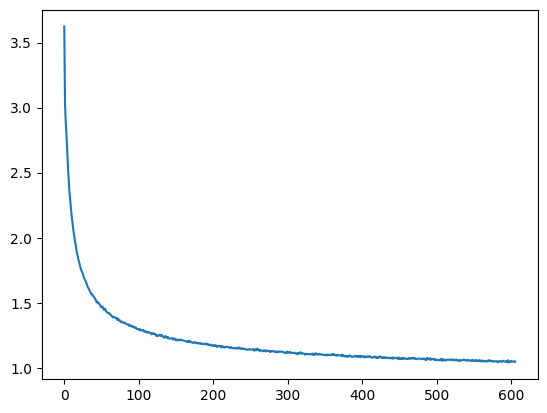

In [15]:
plt.plot(torch.tensor(l).view(-1, 10).mean(1).numpy())

In [16]:
begin_text = torch.tensor(tok.encode('def'), device=device).unsqueeze(0)
print(''.join(tok.decode(generate_batch(model, begin_text))))

def partition(uvalue, sockColumn):
            raise ValueError("No :class:`Row``, over a a transform when condition and Convert a SQL types at :func:`DataFrame.ifSchema.toAurecordType` to the specified reverse to the given formSt (b, len(goneuter)).map(self._java_matrix_wrapper._jdf.groupBy(lambda v: 


In [17]:
# 将层归一化放到在LSTM神经元里面
class LSTMLayerNormCell(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        combined_size = self.input_size + self.hidden_size
        self.gates = nn.Linear(
            combined_size, 4 * self.hidden_size, bias=False)
        self.ln_gates = nn.LayerNorm(4 * self.hidden_size)
        self.ln_c = nn.LayerNorm(self.hidden_size)

    def forward(self, inputs, state=None):
        B, _ = inputs.shape  # (B, I)
        # state: ((B, H), (B, H))
        if state is None:
            state = self.init_state(B, inputs.device)
        hs, cs = state
        combined = torch.cat((inputs, hs), dim=1)  # (B, I + H)
        i, f, c, o = self.ln_gates(self.gates(combined)).chunk(4, 1)
        ingate = F.sigmoid(i)      # (B, H)
        forgetgate = F.sigmoid(f)  # (B, H)
        outgate = F.sigmoid(o)     # (B, H)
        # 更新细胞状态
        ncs = F.tanh(c)            # (B, H)
        cs = self.ln_c((forgetgate * cs) + (ingate * ncs))  # (B, H)
        # 更新隐藏状态
        hs = outgate * F.tanh(cs)                           # (B, H)
        return hs, cs

    def init_state(self, B, device):
        cs = torch.zeros((B, self.hidden_size), device=device)
        hs = torch.zeros((B, self.hidden_size), device=device)
        return hs, cs

class LSTMLayerNorm(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = LSTMLayerNormCell(self.input_size, self.hidden_size)

    def forward(self, inputs, state=None):
        re = []
        # B batch_size,
        # T sequence length,
        # C number of channels.
        B, T, C = inputs.shape
        inputs = inputs.transpose(0, 1)  # (T, B, C)
        for i in range(T):
            state = self.lstm(inputs[i], state)
            re.append(state[0])  # state[0]: (B, H)
        result_tensor = torch.stack(re, dim=0)  # (T, B, H)
        return result_tensor.transpose(0, 1)    # (B, T, H)

In [18]:
class CharLSTMLayerNorm(nn.Module):

    def __init__(self, vs):
        super().__init__()
        self.emb_size = 256
        self.hidden_size = 128
        self.embedding = nn.Embedding(vs, self.emb_size)
        self.dp = nn.Dropout(0.4)
        self.lstm1 = LSTMLayerNorm(self.emb_size, self.hidden_size)
        self.lstm2 = LSTMLayerNorm(self.hidden_size, self.hidden_size)
        self.lstm3 = LSTMLayerNorm(self.hidden_size, self.hidden_size)
        self.h2o = nn.Linear(self.hidden_size, vs)

    def forward(self, x):
        # x: (B, T)
        emb = self.embedding(x)       # (B, T,  C)
        h = self.dp(self.lstm1(emb))  # (B, T,  H)
        h = self.dp(self.lstm2(h))    # (B, T,  H)
        h = self.dp(self.lstm3(h))    # (B, T,  H)
        output = self.h2o(h)          # (B, T, vs)
        return output

model_norm = CharLSTMLayerNorm(len(tok.char2ind)).to(device)

In [19]:
l_norm = train_lstm(model_norm, optim.Adam(model_norm.parameters(), lr=learning_rate),
                    train_loader)

epoch  0: train loss 1.1342, test loss 1.2981
epoch  1: train loss 0.9863, test loss 1.1823
epoch  2: train loss 0.9283, test loss 1.1456
epoch  3: train loss 0.8908, test loss 1.1117
epoch  4: train loss 0.8742, test loss 1.1144
epoch  5: train loss 0.8481, test loss 1.0984
epoch  6: train loss 0.8359, test loss 1.0962
epoch  7: train loss 0.8202, test loss 1.0890
epoch  8: train loss 0.8229, test loss 1.0829
epoch  9: train loss 0.8128, test loss 1.0881


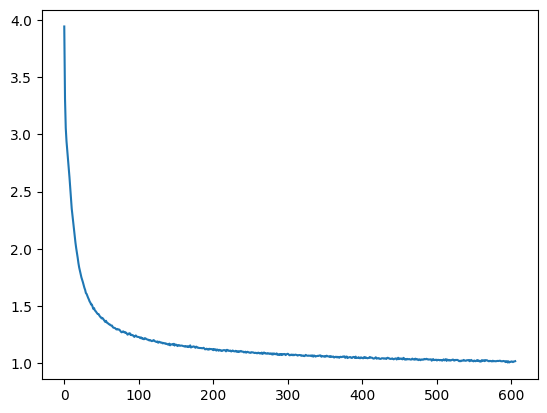

In [20]:
plt.plot(torch.tensor(l_norm).view(-1, 10).mean(1).numpy())

In [23]:
begin_text = torch.tensor(tok.encode('def '), device=device).unsqueeze(0)
print(''.join(tok.decode(generate_batch(model_norm, begin_text))))

def numValues(tempfile.mkdtemp(), df.j1).collect()
        [Row(age2=5, name=u'Alice')]
        """
        if len(other) >= 3:
            raise ValueError("Correlation in a sustance with the bases to and batching with Value thes no data,
        while heap is expected.
        """
        def returnTy
